In [1]:
from astropy.io import fits
from astropy.coordinates import SkyCoord
from astropy import units as u
import numpy as np
from scipy.stats import gaussian_kde
from astropy.cosmology import Planck18 as cosmo
from scipy.spatial import cKDTree

import matplotlib
from matplotlib import pyplot as plt

# import fitsio
from scipy.spatial.distance import cdist

from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import KernelDensity  

from sklearn.neighbors import KNeighborsRegressor
from sklearn.impute import KNNImputer
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split


## kNN method checking

1. Quaia 
2. DESI
3. SDSS

In [2]:
#Main fits file: quasar catalogue with already matched into Quaia
with fits.open("Quaia_DESIQSO_DR1_SDSS.fits") as superset:
    data = superset[1].data.copy()
    header = superset[1].header.copy()

### Quaia only consider, 
again, by the Regressor method only

In [3]:
#based train data setup
train_mask = (~np.isnan(data['redshift_quaia']))
train_data = data[train_mask]

print("number of train_mask:", np.sum(train_mask))

#features - colour bands, to advance the redshift estimations
features = ['phot_g_mean_mag', 'phot_bp_mean_mag', 'phot_rp_mean_mag',
            'mag_w1_vg', 'mag_w2_vg'
            ] #didn't add the Quaia W12 or anything magnitude diffs.

#test data setup
valid_mask = (~np.isnan(data['redshift_quaia']))
filtered_data = data[valid_mask]

X_train = np.array([filtered_data[f] for f in features]).T
y_train = filtered_data['redshift_quaia']

X_test = np.array([filtered_data[f] for f in features]).T
y_test = filtered_data['redshift_quaia']

print("X_train NaN 개수:", np.isnan(X_train).sum())
print("X_test NaN 개수:", np.isnan(X_test).sum())
print("X_test shape:", X_test.shape)
print("각 feature 별 NaN 개수:", np.isnan(X_test).sum(axis=0))
print("test_mask에서 True 개수:", np.sum(valid_mask))

imputer = SimpleImputer(strategy='mean')  # Nan values -> mean values

# scaling
scaler = StandardScaler() #Scaling the value of magnitudes from colour bands to use it within the distance weight

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

for name, mean, var in zip(features, scaler.mean_, scaler.var_):
    print(f"{name}: mean = {mean:.4f}, std = {np.sqrt(var):.4f}")

knn = KNeighborsRegressor(n_neighbors=11, weights='distance', metric='euclidean')
knn.fit(X_train, y_train)

# kNN prediction
z_phot_predictions = knn.predict(X_test)

y_pred_train = knn.predict(X_train)
mae = mean_absolute_error(y_train, y_pred_train)
# rmse = mean_squared_error(y_train, y_pred_train, squared=False)
    #This rmse didn't work due to windows OS properties

print(f"MAE: {mae:.4f}")
print(z_phot_predictions[:5])

number of train_mask: 1295502
X_train NaN 개수: 0
X_test NaN 개수: 0
X_test shape: (1295502, 5)
각 feature 별 NaN 개수: [0 0 0 0 0]
test_mask에서 True 개수: 1295502
phot_g_mean_mag: mean = 19.7056, std = 0.6650
phot_bp_mean_mag: mean = 19.8970, std = 0.6692
phot_rp_mean_mag: mean = 19.2151, std = 0.6707
mag_w1_vg: mean = 15.8877, std = 0.8733
mag_w2_vg: mean = 14.8198, std = 0.8914
MAE: 0.0000
[0.41686687 1.73646808 1.51304924 2.42263198 2.85285378]


In [4]:
nan_mask_test = np.isnan(X_test).any(axis=1)

print("z_phot_predictions shape:", z_phot_predictions.shape)
print("z_phot_predictions sample:", z_phot_predictions[:10])

print("test_mask에서 True 개수:", np.sum(valid_mask))

new_col_zphot = np.full(data.shape[0], np.nan) 

test_indices = np.where(valid_mask)[0]
valid_test_indices = test_indices[~nan_mask_test]  

# Adding the estimated values into new fits files
new_col_zphot[valid_test_indices] = z_phot_predictions

new_cols = fits.ColDefs([
    fits.Column(name='Photo_z_QD', format='E', array=new_col_zphot)
])

hdu = fits.BinTableHDU.from_columns(data.columns + new_cols, header=header)

hdu.writeto("kNNquaiaonly.fits", overwrite=True)

z_phot_predictions shape: (1295502,)
z_phot_predictions sample: [0.41686687 1.73646808 1.51304924 2.42263198 2.85285378 1.406
 0.82163829 0.80347979 2.54347634 1.03626335]
test_mask에서 True 개수: 1295502


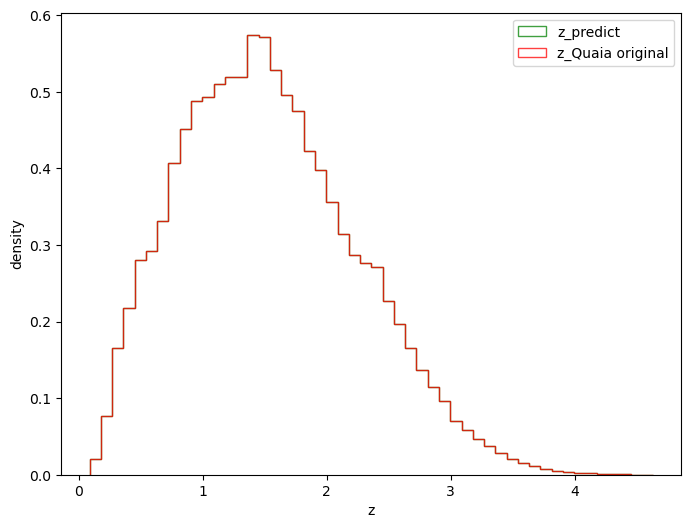

In [5]:
with fits.open("kNNquaiaonly.fits") as quaiaonly:
    qdata = quaiaonly[1].data

qredshift = qdata["Photo_z_QD"]

#histogram
alpha = 0.75
lw = 1.5
density = True
histtype = 'step'

plt.figure(figsize=(8,6))
plt.hist(qredshift, bins=50, alpha=alpha, color='g', lw=lw, density=density, histtype=histtype, label='z_predict')
plt.hist(qdata['redshift_quaia'], bins=50, alpha=alpha, color='r', lw=lw, density=density, histtype=histtype, label='z_Quaia original')

plt.xlabel('z')
plt.ylabel('density')
plt.legend()

checking the quaia only by plotting histogram and scatter graph

As expected, since the superset itself is quaia-based, it is actually very obvious thing that trained and test data is following exactly same to quaia.
This means that kNN Regressor works well, within the distance weighted.

### DESI only

In [47]:
#based train data setup
dtrain_mask = (~np.isnan(data['DESI_Z']))
dtrain_data = data[dtrain_mask]

print("number of train_mask:", np.sum(dtrain_mask))

#features - colour bands, to advance the redshift estimations
features = ['phot_g_mean_mag', 'phot_bp_mean_mag', 'phot_rp_mean_mag',
            'mag_w1_vg', 'mag_w2_vg'
            ] #didn't add the Quaia W12 or anything magnitude diffs.
                #In this features, quaia colour bands are used since the original fits file is cross-matched files.

#test data setup
dvalid_mask = (~np.isnan(data['redshift_quaia']))
dfiltered_data = data[dvalid_mask]

X_dtrain = np.array([dfiltered_data[f] for f in features]).T
y_dtrain = dfiltered_data['DESI_Z']

X_dtest = np.array([dfiltered_data[f] for f in features]).T
y_dtest = dfiltered_data['redshift_quaia']

print("X_train NaN 개수:", np.isnan(X_dtrain).sum())
print("X_test NaN 개수:", np.isnan(X_dtest).sum())
print("X_test shape:", X_dtest.shape)
print("각 feature 별 NaN 개수:", np.isnan(X_dtest).sum(axis=0))
print("test_mask에서 True 개수:", np.sum(dvalid_mask))

imputer = SimpleImputer(strategy='mean')  # Nan values -> mean values

# scaling
scaler = StandardScaler() #Scaling the value of magnitudes from colour bands to use it within the distance weight

X_dtrain = scaler.fit_transform(X_dtrain)
X_dtest = scaler.transform(X_dtest)

for name, mean, var in zip(features, scaler.mean_, scaler.var_):
    print(f"{name}: mean = {mean:.4f}, std = {np.sqrt(var):.4f}")

knn = KNeighborsRegressor(n_neighbors=11, weights='distance', metric='euclidean')
knn.fit(X_dtrain, y_dtrain)

# kNN prediction
dz_phot_predictions = knn.predict(X_dtest)

y_dpred_train = knn.predict(X_dtrain)
mae = mean_absolute_error((~np.isnan(y_dtrain)), (~np.isnan(y_dpred_train)))
# rmse = mean_squared_error(y_train, y_pred_train, squared=False)
    #This rmse didn't work due to windows OS properties

print(f"MAE: {mae:.4f}")
print(dz_phot_predictions[:5])

number of train_mask: 314807
X_train NaN 개수: 0
X_test NaN 개수: 0
X_test shape: (1295502, 5)
각 feature 별 NaN 개수: [0 0 0 0 0]
test_mask에서 True 개수: 1295502
phot_g_mean_mag: mean = 19.7056, std = 0.6650
phot_bp_mean_mag: mean = 19.8970, std = 0.6692
phot_rp_mean_mag: mean = 19.2151, std = 0.6707
mag_w1_vg: mean = 15.8877, std = 0.8733
mag_w2_vg: mean = 14.8198, std = 0.8914
MAE: 0.2430
[nan nan nan nan nan]


In [41]:
nan_dmask_test = np.isnan(X_dtest).any(axis=1)

print("z_phot_predictions shape:", dz_phot_predictions.shape)
print("z_phot_predictions sample:", dz_phot_predictions[:10])

print("test_mask에서 True 개수:", np.sum(dvalid_mask))

new_col_zphot = np.full(data.shape[0], np.nan) 

test_indices = np.where(dvalid_mask)[0]
valid_test_indices = test_indices[~nan_dmask_test]  

# Adding the estimated values into new fits files
new_col_zphot[valid_test_indices] = dz_phot_predictions

new_cols = fits.ColDefs([
    fits.Column(name='Photo_z_QD', format='E', array=new_col_zphot)
])

hdu = fits.BinTableHDU.from_columns(data.columns + new_cols, header=header)

hdu.writeto("kNNtest.fits", overwrite=True)

z_phot_predictions shape: (314807,)
z_phot_predictions sample: [0.40997237 1.74039672 1.50299691 2.42418878 2.86977807 1.52914835
 0.81040696 0.81954735 2.53007464 1.04515074]
test_mask에서 True 개수: 314807


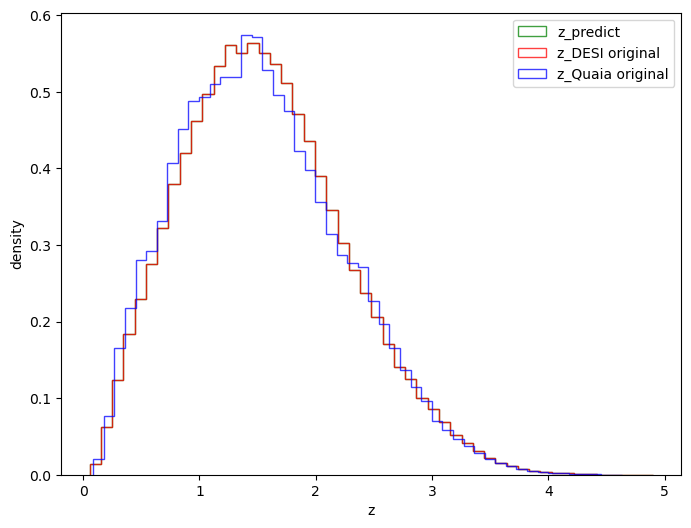

In [42]:
with fits.open("kNNtest.fits") as desionly:
    ddata = desionly[1].data

dredshift = ddata["Photo_z_QD"]

#histogram
alpha = 0.75
lw = 1.5
density = True
histtype = 'step'

plt.figure(figsize=(8,6))
plt.hist(dredshift, bins=50, alpha=alpha, color='g', lw=lw, density=density, histtype=histtype, label='z_predict')
plt.hist(ddata["DESI_Z"], bins=50, alpha=alpha, color='r', lw=lw, density=density, histtype=histtype, label='z_DESI original')
plt.hist(qdata['redshift_quaia'], bins=50, alpha=alpha, color='b', lw=lw, density=density, histtype=histtype, label='z_Quaia original')


plt.xlabel('z')
plt.ylabel('density')
plt.legend()

Text(0, 0.5, 'number per bin')

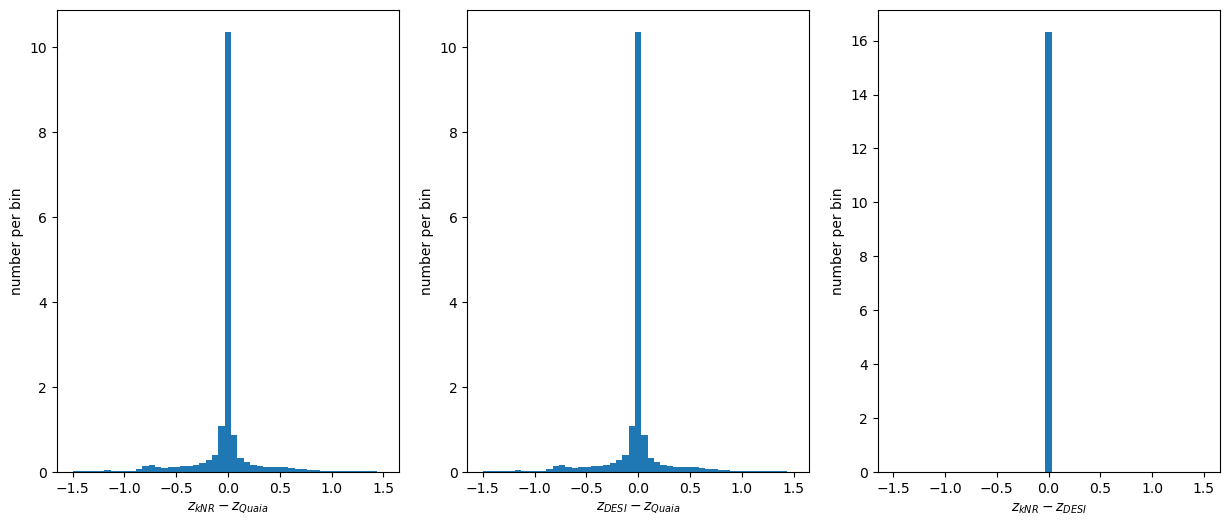

In [45]:
plt.figure(figsize=(15, 6))

bins = np.linspace(-1.5, 1.5, 50)

plt.subplot(1, 3, 1)
plt.hist(dredshift - ddata["redshift_quaia"], bins=bins, density=True)
plt.xlabel(r'$z_{kNR} - z_{Quaia}$')
plt.ylabel('number per bin')

plt.subplot(1, 3, 2)
plt.hist(ddata["DESI_Z"] - ddata["redshift_quaia"], bins=bins, density=True)
plt.xlabel(r'$z_{DESI} - z_{Quaia}$')
plt.ylabel('number per bin')

plt.subplot(1, 3, 3)
plt.hist(dredshift - ddata["DESI_Z"], bins=bins, density=True)
plt.xlabel(r'$z_{kNR} - z_{DESI}$')
plt.ylabel('number per bin')

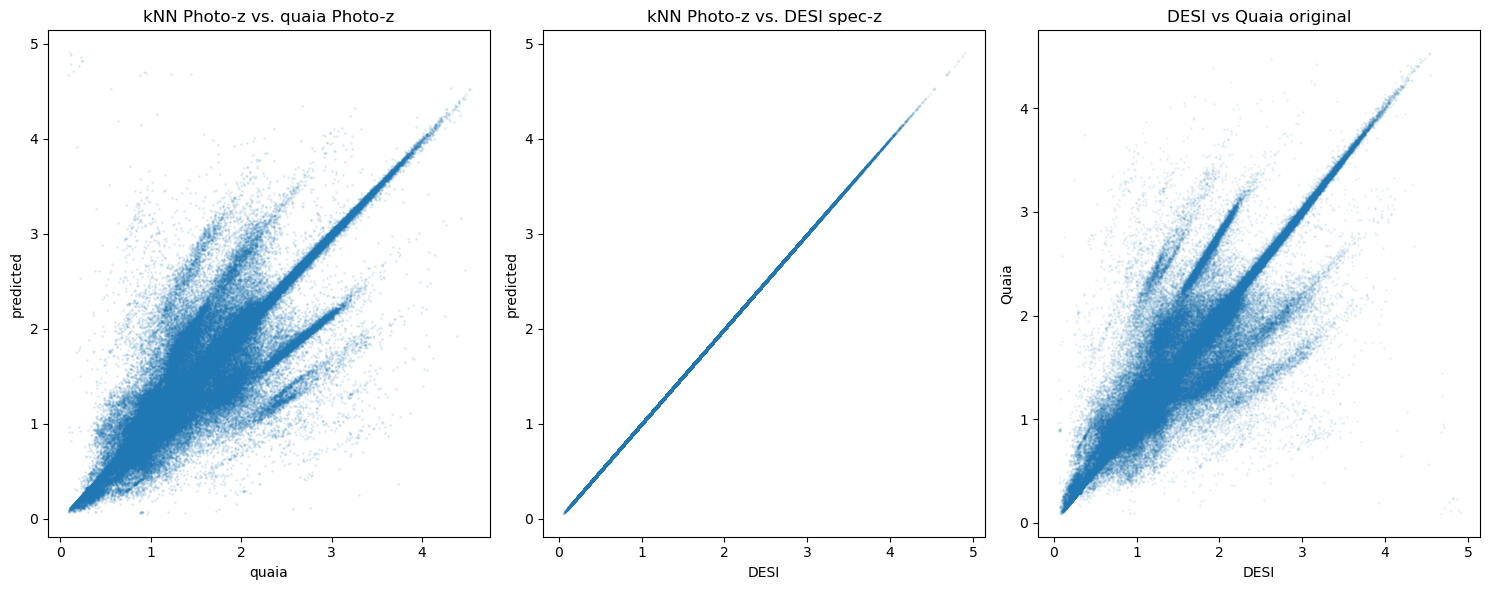

In [46]:
plt.figure(figsize=(15, 6))

plt.subplot(1, 3, 1)
plt.scatter(ddata['redshift_quaia'], dredshift, alpha=0.1, s=1)
plt.xlabel("quaia")
plt.ylabel("predicted")
plt.title("kNN Photo-z vs. quaia Photo-z")

plt.subplot(1, 3, 2)
plt.scatter(ddata['DESI_Z'], dredshift, alpha=0.07, s=1)
plt.xlabel("DESI")
plt.ylabel("predicted")
plt.title("kNN Photo-z vs. DESI spec-z")

plt.subplot(1, 3, 3)
plt.scatter(ddata['DESI_Z'], ddata['redshift_quaia'], alpha=0.07, s=1)
plt.xlabel("DESI")
plt.ylabel("Quaia")
plt.title("DESI vs Quaia original")

plt.tight_layout()
plt.show()


In [20]:
# matched catalogue checking
qdfits = fits.open("Matched_Quaia_DESI_Catalog.fits")

qdfits[1].header

XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                   96 / length of dimension 1                          
NAXIS2  =                16659 / length of dimension 2                          
PCOUNT  =                    0 / number of group parameters                     
GCOUNT  =                    1 / number of groups                               
TFIELDS =                   16 / number of table fields                         
TTYPE1  = 'DESI_RA '                                                            
TFORM1  = 'D       '                                                            
TTYPE2  = 'DESI_DEC'                                                            
TFORM2  = 'D       '                                                            
TTYPE3  = 'DESI_Z  '        